# PREDICTING HOW PLAYERS PLAY MINECRAFT ON A VIDEO GAME RESEARCH SERVER (PLAICRAFT)

## INTRODUCTION
A research group at UBC, named The Pacific Laboratory for Artificial Intelligence (PLAI). They started this Minecraft server, a sandbox game, in hopes to get over 10,000 hours of multiplayer gameplay. Then they will proceed to use this data to train AI-like agents that will be able to respond more human-like towards visual and audio environments. In other words, develop smarter NPCs (Non-Player Characters). 

Our group will be answering the question **What "kind" of players are most likely to contribute a large amount of data so that the PLAI research group can target those players in their recruiting efforts.**

For this project, we have decided that we will focus on using age to predict if a player will contribute a lot of hours towards the data. To do this, we have been given a data by the PLAI group of players who have already contributed to a bit of the data. We will be wrangling the data to only focus on the two variables required: age and played hours. Then we will be using KNN Regression and (predict ages?) (see if there is a relationship? i dont frickin know). 

In [2]:
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [12]:
#first we read the data from the link provided 

player_data <- read_csv("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")
head(player_data)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


**Table 1.0: Initial Data Table**

In [13]:
set.seed(2006)
#We can see that there are participants who are not contributing much data to the played hours. 
#We fixed this by filtering out the data, which would help avoid overplotting unnecessary data. Keeping only those who have
#played more than 0.0 hours

cleaned_players <- player_data |>
    filter(played_hours > 0.0) |>
    select("age", "played_hours")

head(cleaned_players)

age,played_hours
<dbl>,<dbl>
9,30.3
17,3.8
21,0.7
21,0.1
17,0.1
23,1.6


**Table 2.0: Data Table after filtering and selecting only variables that we will be using**

In [15]:
set.seed(2006)
#split data into test and train first before we do any training. Only use the training data so that at the very end, we can use
#unseen data to test how well our model performs

players_split <- initial_split(cleaned_players, prop = 0.6, strata = played_hours) 
players_train <- training(players_split)
players_test <- testing(players_split)

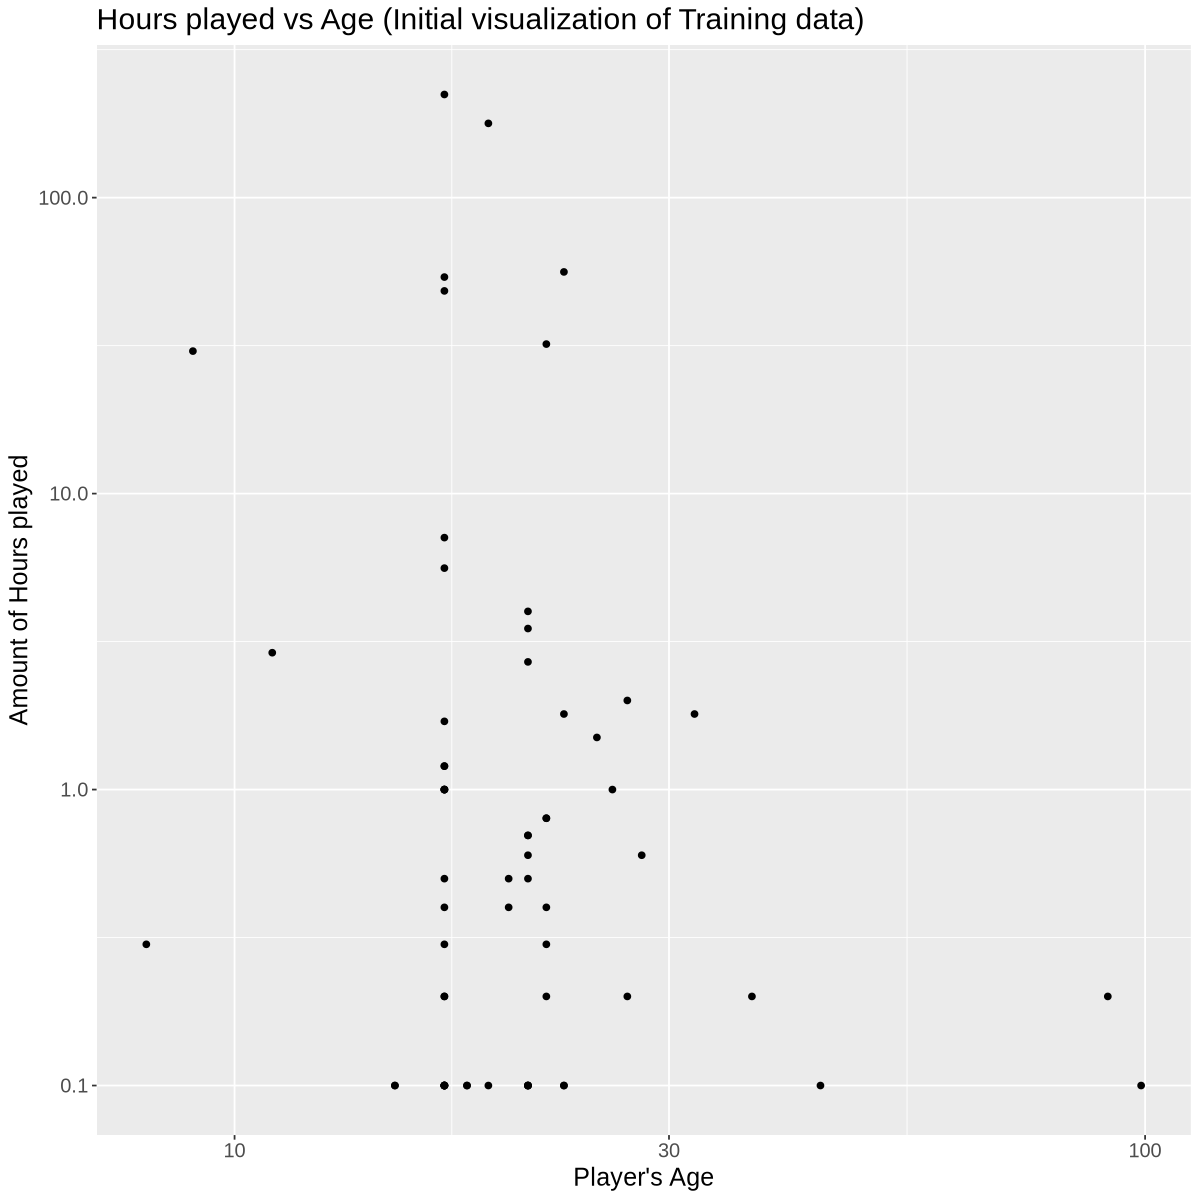

In [16]:
set.seed(2006)

#graph initial training data to kind of get an idea of what we're working with 
options(repr.plot.width = 10, repr.plot.height = 10)

players_train_plot <- players_train |>
    ggplot(aes(x = age, y = played_hours)) +
    geom_point() +
    labs(x = "Player's Age", y = "Amount of Hours played")+ 
    ggtitle("Hours played vs Age (Initial visualization of Training data)") + 
    scale_x_log10(labels = label_comma())+
    scale_y_log10(labels = label_comma())+
    theme(text = element_text(size = 15))

players_train_plot

**FIGURE 1: Graph of Training data - Putting up player's age vs Amount of played hours**

In [17]:
set.seed(2006) 
#from the plot (FIGURE 1), we see that there isn't really a distinct linear relationship between the player's age and amount 
#of hours played

#Therefore, we will be using knn regression 
#We first create the model and recipe 

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

players_recipe <- recipe(played_hours ~ age, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec
players_recipe

K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 




── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 1



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



In [18]:
set.seed(2006)

#create vfold 
players_vfold <- vfold_cv(players_train, v = 5, strata = played_hours) 

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 3 breaks instead.”


In [19]:
#create workflow 

players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) 

players_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [20]:
set.seed(2006)

#find which k value would be the best our of 50 k values - half of the values of our total observations used

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1)) 

k_results <- players_workflow |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "rmse") |>
    slice_min(mean, n = 1)

k_results

→ A | warning: 50 samples were requested but there were 52 rows in the data. 47 will be used.

There were issues with some computations   A: x1

There were issues with some computations   A: x5





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
49,rmse,standard,31.11169,5,9.48668,Preprocessor1_Model49


**Table 3.0: RMSE Value with our best k value, tuned by training data**

In [21]:
set.seed(2006)

#test how well our model does on predicting unseen data
k_min <- k_results |>
        pull(neighbors)

players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
        set_engine("kknn") |>
        set_mode("regression")

players_bestfit <- workflow() |>
        add_recipe(players_recipe) |>
        add_model(players_best_spec) |>
        fit(data = players_train)

players_summary <- players_bestfit |>
        predict(players_test) |>
        bind_cols(players_test) |>
        metrics(truth = played_hours, estimate = .pred) |>
        filter(.metric == "rmse")
        

players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,37.95341


**Table 4.0: RMSPE value on testing set with best number of neighbors(49)**

## Final Verdict or wahtever its called

(Uh idk what im saying here, i hope u guys get my idea. pls fix it idk what im saying)
After picking the most ideal k value out of 50 that was tested on. It shows that the best neighbor values to have is 49. 

(talk abnt what rmspe means. average difference between predicted response vs actual response) 
(because 37 basically saying, on avrg, model will have an discrepency between actual vs predicted respnse by around 37 hours...(about cause we scale logged it + standardization) :))
(no under/over fitting because rmspe vs rmse difference is relatively low, only 6)

Testing this on our unseen data. We get an rmspe value of 37.95. Comparing that to when we were tuning and picking the best k value on training data. It is not terrible. And could be somewhat reliable. 

(errors could also be because we did not exclude any outliers: players that are playing 200 hours? and players who have an age of 91 like bffr you are not 91 years old hopping on minecraft)

However, the model could definitely be much better. And due to a somewhat high number, we can also assume that age may not be our best variable to predict played hours. 
Especially due to the data being targetted to a university student population so far, we can logically expect that the most played hours would be from players that are around the ages 17-24.  

(could be because people arent playing enough - data used to create model is still relatively new/not enough played hours from all players
could also be because people are inputting 91 years old??!?!?!)
